ME 781 Project - Group 19

GPU for acceleration

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)


Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#### importing all the libraries

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from matplotlib import image
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model, metrics
import pickle
# import joblib

# sys.modules['sklearn.externals.joblib'] = joblib
from joblib import dump, load



In [ ]:
### mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_images_folder = '\\content\drive\MyDrive\train'            ## insert address of the foldeer containing training images
test_images_folder = '/content/drive/MyDrive/test'              ## insert the address of the folder containing the images you want to deblur
test_image = '/157055.jpg'                                                  ## insert the image file name to deblur

In [ ]:
path = train_images_folder 

In [ ]:
path

'/content/drive/MyDrive/train'

In [ ]:
os.listdir('/content/gdrive/MyDrive/train')

['368016.jpg',
 '61086.jpg',
 '225017.jpg',
 '156079.jpg',
 '254033.jpg',
 '8143.jpg',
 '118020.jpg',
 '196015.jpg',
 '106020.jpg',
 '271031.jpg',
 '138032.jpg',
 '376001.jpg',
 '242078.jpg',
 '60079.jpg',
 '95006.jpg',
 '246016.jpg',
 '112082.jpg',
 '173036.jpg',
 '187083.jpg',
 '24004.jpg',
 '178054.jpg',
 '188063.jpg',
 '216066.jpg',
 '8049.jpg',
 '108041.jpg',
 '314016.jpg',
 '153077.jpg',
 '176035.jpg',
 '187003.jpg',
 '87065.jpg',
 '22013.jpg',
 '124084.jpg',
 '23080.jpg',
 '90076.jpg',
 '23025.jpg',
 '66039.jpg',
 '159045.jpg',
 '23084.jpg',
 '183087.jpg',
 '24063.jpg',
 '35070.jpg',
 '388016.jpg',
 '153093.jpg',
 '12074.jpg',
 '293029.jpg',
 '202012.jpg',
 '118035.jpg',
 '144067.jpg',
 '326038.jpg',
 '140075.jpg',
 '35010.jpg',
 '317080.jpg',
 '245051.jpg',
 '78019.jpg',
 '239007.jpg',
 '183055.jpg',
 '65010.jpg',
 '43070.jpg',
 '353013.jpg',
 '147021.jpg',
 '108073.jpg',
 '134008.jpg',
 '323016.jpg',
 '28075.jpg',
 '368078.jpg',
 '15004.jpg',
 '41025.jpg',
 '166081.jpg',
 '100

In [ ]:

######################################  create a list of image addresses

path = '/content/gdrive/MyDrive/train'                            ## address of the train images folder
imageNames= []                                        ## array to store addresses of every training image
for i in os.scandir(path):                            ## scan through the directore in the path
    imageNames.append(i.path)

len(imageNames)


200

In [ ]:
##########################################  get the Max size of W

maxsize = image.imread(imageNames[0]).shape[0]                  ## random initialization

for i in imageNames:                                            ## scan through all images
    img = image.imread(i)                                       
    
    dim = min(img.shape[0],img.shape[1])                        ## take the min of height and width
    maxsize = min(dim,maxsize)                                  ## compare it to the minimum till present
    
maxsize = maxsize//2
maxsize = 224                                              ## this min value is the size of the largest image patch we can consider for training


In [ ]:
###################################### Add noise function


def noisy(img,noise_typ,mean = 0,var = 1,prob = 0.001):                ## adds noise to image

    if noise_typ == 1:                                         ## gaussian noise
        row,col,ch= img.shape                                     ## get image dimensions
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))         ## matrix with values sampled from a gaussain
        gauss = gauss.reshape(row,col,ch)
        img = (img + gauss)%255                                    ## adds gaussian noise and bring back image into 0-255 intensity values


    elif noise_typ == 2:                                        ## salt and pepper noise

        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img_v = img_hsv[:,:,2]

        row,col = img_v.shape

        
        noise = np.random.rand(row,col)                    ## matrix with values sampled from uniform distribution
        img_v = np.where(noise<prob, 0, img_v)                    ## thresholding of the values
        img_v = np.where(noise>1-prob, 255, img_v)                ## values wihting the threshold become salt/pepper noise respectively

        img_hsv[:,:,2]=  img_v

        img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

    return img

In [ ]:
###########################################
W = maxsize - 1 + (maxsize%2)                                         # Patch max window size


all_patches = []                                                      ## array to store all patches
all_centres = []                                                      ## array to store all the centres of the patches 
original_patches = []


for i in range(len(imageNames)):                                      ## loop over all images

    img = image.imread(imageNames[i])

    max_blur = 7                                                       ## specifying max extent of degradation
    max_var = 2
    max_prob = 0.008

    b = random.randint(1,max_blur)                                  ## randomly selecting parameters determining degradation
    # noise = random.randint(1,2)
    noise=1
    var = random.randint(1,max_var)
    prob = random.uniform(0,max_prob)

    img_blur = cv2.blur(img,(b,b))                                     ## bluring the image
    
    img_noisy = noisy(img_blur,noise, var = var, prob = prob)           ## adding noise to the image

    img_edited = img_noisy

    # plt.imshow(img_edited)
    # plt.show()

   ############################################# Get image patches

    
    numPatches = random.randint(2,50)                       # Number of patches to be extracted from this image is selected at random

    #patches = np.empty((numPatches,W,W,3), dtype=float) # Initilizing patch n-d array

    for i in range(numPatches):                             # For number of patches
        x = random.randint(0, img_edited.shape[0]-W)        # Random x location so that the patch 
                                                               # remains within image boundaries
        y = random.randint(0, img_edited.shape[1]-W)        # Random y location
                                                                # remains within image boundaries
        #patches[i,:,:,:] = img[x:x+W,y:y+W,:]/255.0 # Extract patch
                                            # Divide by 255 for float image

        centre_x = x + W//2                                  ## centre of the patch
        centre_y = y + W//2

        centre = img[centre_x,centre_y,:]                   ##centre pixel of the patch

        # # Display sub-patch
        # plt.imshow(patches[i,np.int((W-w)/2):np.int(W-(W-w)/2),np.int((W-w)/2):np.int(W-(W-w)/2),:])
        # plt.show()

        # all_patches.append(patches[i,:,:,:])
        original_patches.append(img[x:x+W,y:y+W,:])
        all_patches.append(img_edited[x:x+W,y:y+W,:])              ## extract this patch from image and append it to an array of features
        all_centres.append(centre)                             ##and centre of the patch to larger arrays to make a feature vector

all_patches = np.array(all_patches)                         ## storing evruyhting as numpy arrays
all_centres = np.array(all_centres) 
original_patches = np.array(original_patches)




In [ ]:
k = 48
print(all_centres[k])                                   ## just a test pf centre pixel of orignal and patch
i = all_patches[k]
print(i[i.shape[0]//2,i.shape[1]//2,:])
i = original_patches[k]
print(i[i.shape[0]//2,i.shape[1]//2,:])

[200 190 181]
[201.85544169 189.8624787  180.3709102 ]
[200 190 181]


In [ ]:
all_patches.shape                                       ## just a test of size

(4974, 223, 223, 3)

In [ ]:
all_centres.shape                                       ##just a test of size

(4974, 3)

# Generating those ML models

There are 3 models I have tried out:
1. SVR Regression on HSV
2. SVR Regression on RGB channels separately
3. Random forest regression on HSV

These models are less complicated than Neural Network models. Also will work faster

We try these models for patch width ranging from 11 to 71

Anything smaller than 11 would be too small to jydge accurately. Anything largere than 71 would be too much to 
extract a local pixel intensity value and might overfit the model

We would typically observe some optimal value for width, after which, on increasing the width error increase because of overfitting, and the time taken grows extremely too

# Linear Regression

In [ ]:
global regressor_svr_v                                                  ## regression model declared as global variable to use later on actual image

sc_X_v = StandardScaler()                                               ## standard scarler for input and output feature vectors
sc_y_v = StandardScaler()

def linear_regression_v(all_patches,all_centres,w,size):

  subpatches = all_patches[:,(W-w)//2:int(W-(W-w)/2),int((W-w)/2):int(W-(W-w)/2),:]             ## create a subpatch based on the width w (to train the modle on)

  subpatches = np.array([cv2.cvtColor((subpatch).astype(np.uint8), cv2.COLOR_BGR2HSV) for subpatch in subpatches])                            ## convert all the subpatches and centers to hsv intensity values
  all_centres = np.array([cv2.cvtColor(np.resize(centre,(1,1,3)).astype(np.uint8), cv2.COLOR_BGR2HSV) for centre in all_centres])
  subpatches = subpatches[:,:,:,2]
  all_centres = all_centres[...,2]

  X = subpatches                                                ## input to the model
  X = X.reshape(X.shape[0],-1)                                    ## flattened input

  y = all_centres/255.0                                                 ## output vectors
  y=y.reshape(-1,1)                                              


  X = sc_X_v.fit_transform(X)                                     ## fit the standard scaler and transform the input to 0 mean unit

  # y = sc_y_v.fit_transform(y)                                          ## and output feature vectors
  y = y.reshape(-1)

  # splitting X and y into training and testing sets

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                            random_state=1)

  # create linear regression object
  reg = linear_model.LinearRegression()

  # train the model using the training sets
  reg.fit(X_train, y_train)

  # regression coefficients
  # print('Coefficients: ', reg.coef_)

  # variance score: 1 means perfect prediction
  # print('Variance score: {}'.format(reg.score(X_test, y_test)))
  print(reg.score(X_test, y_test))

  return reg.score(X_test, y_test)

  # plot for residual error

  # ## setting plot style
  # plt.style.use('fivethirtyeight')

  # ## plotting residual errors in training data
  # plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
  #       color = "green", s = 10, label = 'Train data')

  # ## plotting residual errors in test data
  # plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
  #       color = "blue", s = 10, label = 'Test data')

  # ## plotting line for zero residual error
  # plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)

  # ## plotting legend
  # plt.legend(loc = 'upper right')

  # ## plot title

  # plt.title("Residual errors")

  # ## method call for showing the plot
  # plt.show()


11 - 0.9052842331220674
21 - 0.8781697098714386
31 - 0.640458632991316
41 - -0.02215022446722892
51 - -5.082584047719024
61 - -3.0250050995030193
71 - -0.611075445131483
81 - 0.052356758199229025
91 - 0.3910167992221798
101 - 0.4621528903863681
111 - 0.5518001087746839
121 - 0.6070112816966269
131 - 0.6468167439394301
141 - 0.6674089646873347
151 - 0.676038279074976
161 - 0.6768956438117821
171 - 0.696040813945604


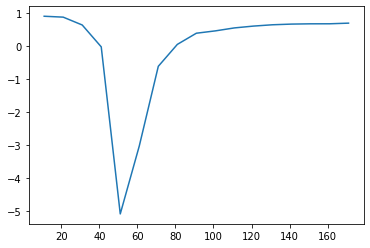

In [ ]:
test_size = 0.1                             ## test train split size
width = 171                                ## width of the subpatches


rmse = []                             ## initalised array to store error for all width sizes
for w in range(11,width+1,10):                ## looping over subpacth width
  print(w,end=' - ')
  rmse.append(linear_regression_v(all_patches,all_centres,w,test_size))           ## cal;culate rmse for various width sizes

plt.plot(range(11,width+1,10),rmse)                                                    ## plot the trend
plt.show()

## Support vector regression

In [ ]:
########### support vector regression based on v values

global regressor_svr_v                                                  ## regression model declared as global variable to use later on actual image

sc_X_v = StandardScaler()                                               ## standard scarler for input and output feature vectors
sc_y_v = StandardScaler()


def support_vector_regression_v(all_patches,all_centres,w,size):        ## function to train and test a model for a given set of input and outputs

  global regressor_svr_v

  subpatches = all_patches[:,(W-w)//2:int(W-(W-w)/2),int((W-w)/2):int(W-(W-w)/2),:]             ## create a subpatch based on the width w (to train the modle on)

  subpatches = np.array([cv2.cvtColor((subpatch).astype(np.uint8), cv2.COLOR_BGR2HSV) for subpatch in subpatches])                            ## convert all the subpatches and centers to hsv intensity values
  all_centres = np.array([cv2.cvtColor(np.resize(centre,(1,1,3)).astype(np.uint8), cv2.COLOR_BGR2HSV) for centre in all_centres])
  subpatches = subpatches[:,:,:,2]
  all_centres = all_centres[...,2]

  X = subpatches                                                ## input to the model
  X = X.reshape(X.shape[0],-1)                                    ## flattened input
  

  y = all_centres/255.0                                                 ## output vectors
  y=y.reshape(-1,1)                                              
  

  X = sc_X_v.fit_transform(X)                                     ## fit the standard scaler and transform the input to 0 mean unit
  
  # y = sc_y_v.fit_transform(y)                                          ## and output feature vectors
  y = y.reshape(-1)
  

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= size)            ## test train split on the input and output

  regressor_svr_v = SVR(kernel = 'rbf')
  # regressor_svr_v = SVR(kernel = 'poly')                                                ##train the polynomial svr regression model
  regressor_svr_v.fit(X_train, y_train)                                                   ## on the training dataset

  y_pred = regressor_svr_v.predict(X_test)                                              ##predict the output on the test dataset

  mse = mean_squared_error(y_pred,y_test)                                 ## calculate the  mse
  rmse = np.sqrt(mse)                                                                   ## calculate the rmse
  print(rmse)

  return rmse                                                                            ## return the %rmse value for this model
  


11 - 0.07377618318706103
21 - 0.08040147464352411
31 - 0.0863899397859017
41 - 0.0971039019678707
51 - 0.10265563679894549
61 - 0.10986499297041549
71 - 0.11241060512273769


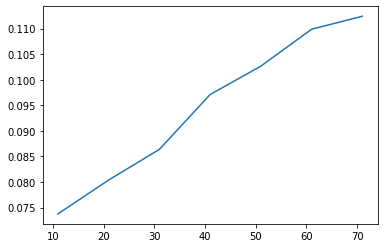

In [ ]:
test_size = 0.1                             ## test train split size
width = 71                                ## width of the subpatches


rmse = []                             ## initalised array to store error for all width sizes
for w in range(11,width+1,10):                ## looping over subpacth width
  print(w,end=' - ')
  rmse.append(support_vector_regression_v(all_patches,all_centres,w,test_size))           ## cal;culate rmse for various width sizes

plt.plot(range(11,width+1,10),rmse)                                                    ## plot the trend
plt.show()

In [ ]:
min_value = min(rmse)
w_min_svr_v = (rmse.index(min_value)+1)*10+1
w_min_svr_v

11

## Random Forest Regression

In [ ]:
########### support vector regression on v values

global regressor_rfr_v                                          ## regression model declared as global variable to use later on actual image

sc_X_v = StandardScaler()                                       ## standard scarler for input and output feature vectors
# sc_y_v = StandardScaler()


def random_forest_regression_v(all_patches,all_centres,w,size, n=10, depth=10):

  global regressor_rfr_v                                        ## function to train and test a model for a given set of input and outputs

  subpatches = all_patches[:,(W-w)//2:int(W-(W-w)/2),int((W-w)/2):int(W-(W-w)/2),:]                 ## create a subpatch based on the width w (to train the modle on)

  subpatches = np.array([cv2.cvtColor((subpatch).astype(np.uint8), cv2.COLOR_BGR2HSV) for subpatch in subpatches])                    ## convert all the subpatches and centers to hsv intensity values
  all_centres = np.array([cv2.cvtColor(np.resize(centre,(1,1,3)).astype(np.uint8), cv2.COLOR_BGR2HSV) for centre in all_centres])
  subpatches = subpatches[:,:,:,2]
  all_centres = all_centres[...,2]

  X = subpatches                                                                ## input to the model
  X = X.reshape(X.shape[0],-1)                                                  ## flattened input
  y = all_centres/255.0                                                         ## output vectors
  y=y.reshape(-1,1)
  # print(y.shape)

  X = sc_X_v.fit_transform(X)                                                   ## fit the standard scaler and transform the input to 0 mean unit
  # y = sc_y_v.fit_transform(y)
  y = y.reshape(-1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= size)      ## test train split on the input and output

  regressor_rfr_v = RandomForestRegressor(n_estimators = n, max_depth = depth)        ##train the rfr regression model
  regressor_rfr_v.fit(X_train, y_train)                                               ## on the training dataset

  # print(X_train.shape)
  # print(y_train.shape)
  # print(X_test.shape)
  # print(y_test.shape)

  y_pred = regressor_rfr_v.predict(X_test)                                            ##predict the output on the test dataset

  ### error after inverse transform
  # y_pred=y_pred.reshape(-1,1)
  # y_pred = sc_y_v.inverse_transform(y_pred)
  # y_pred = y_pred.reshape(-1)

  # y_test=y_test.reshape(-1,1)
  # y_test = sc_y_v.inverse_transform(y_test)
  # y_test = y_test.reshape(-1)

  # print(y_pred[0])
  # print(y_test[0])

  mse = mean_squared_error(y_pred,y_test)                                             ## calculate the mse
  rmse = np.sqrt(mse)                                                                 ## calculate the % rmse

  print(rmse)

  return rmse                                                                         ## return the %rmse value for this model
  

1 - 0.07761996435292917
11 - 0.0662715503504003
21 - 0.06631090387602859
31 - 0.06933925477021463
41 - 0.06612458410289004
51 - 0.06920767146805919
61 - 0.06786017220686481
71 - 0.06441687364434635
81 - 0.07135711938169154
91 - 0.06170955379497841
101 - 0.06767322770653322


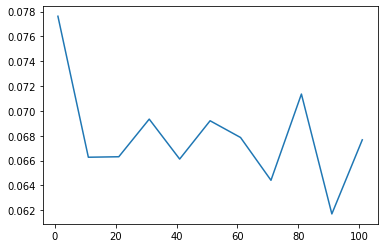

In [ ]:
test_size = 0.33
width = 101
n = 30
depth = 20
rmse = []
for w in range(1,width+1,10):
  print(w,end=' - ')
  rmse.append(random_forest_regression_v(all_patches,all_centres,w,test_size, n = n, depth = depth))

plt.plot(range(1,width+1,10),rmse)
plt.show()

In [ ]:
min_value = min(rmse)
w_min_rfr_v = rmse.index(min_value)*10+1
w_min_rfr_v

91

We found out the optimum w for all these 3 models, and we will use patches of this size in the image to test, in order to estimate the centre pixel

# Applying model on actual images 

## image selection


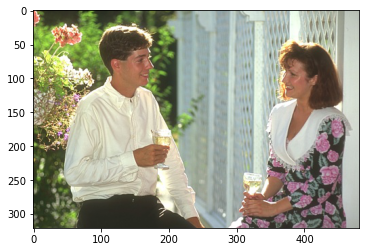

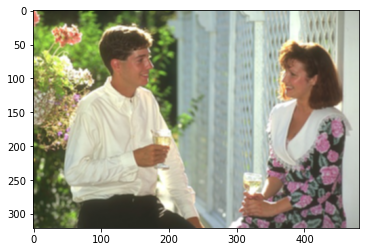

In [ ]:
######################################### take an image to deblurr (but first blur it)

path = test_images_folder                                       ## test image folder location

img = image.imread(test_images_folder+test_image)               ## read the test image
plt.imshow(img/255.0)                                           ## display the test image
plt.show()

blur = True

if blur:

  max_blur = 5                                                    ## maximum degradation parameters set
  max_var = 10
  max_prob = 0.008

  b = random.randint(1,max_blur)                                  ## randomly set degradation parameters
  noise = random.randint(1,2)
  var = random.randint(1,max_var)
  prob = random.uniform(0,max_prob)

  img_blur = cv2.blur(img,(b,b))                                   ## blur the original image  #### use this only if needed
  # img_blur = noisy(img_blur,noise, var = var, prob = prob)           ## adding noise to the image
  img = img_blur

  plt.imshow(img/255.0)                                           ## display the test image
  plt.show()

## Applying SVR

In [ ]:
model = 'svr'                                     ## model to apply to the image to deblur
# model = 'svr_rgb'
# model = 'rfr'

0.07316869777354007
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320


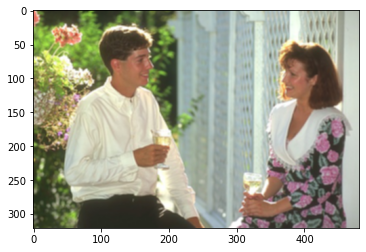

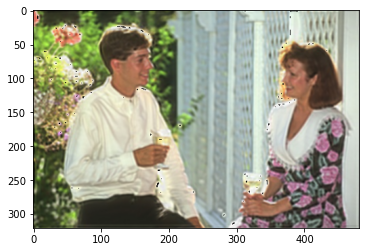

In [ ]:
 ################################### applying svr model to the image (only on the v values)

if model == 'svr':


  img_hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2HSV)                      ## convert bgr image to hsv
  img_v = img_hsv[:,:,2]                                                                ## extract intensity values

  # w_max = w_min_svr_v                                                                            ## set optimum width for subpatches to generate centre pixel value
  w_max = 11

  out = np.zeros([img_v.shape[0],img_v.shape[1]])                                       ## initliase array to store output
  out2 = np.zeros([img_v.shape[0],img_v.shape[1]])                                      ## used to creat a copy of the original to compare with output

  img_padded = np.pad(img_v,((w_max//2,w_max//2),(w_max//2,w_max//2)),'mean')           ## add padding to the image (half the width of the subpatch on each side)
  # print(img_padded.shape)

  support_vector_regression_v(all_patches,all_centres,w_max,0.1)                  ## call the model to train it once (OPTION)

  for row in range(img.shape[0]):                                                       ## traverse along rows
    if row%10==0:
      print(row)                                                                        ## to keep a track of image processed because it takes time
    for column in range(img.shape[1]):                                                  ## traverse laong columns (cells)
      X = img_padded[row:row+w_max,column:column+w_max].flatten().reshape(1,-1)             ## for each pixel, select a wxw width box of image
      X = sc_X_v.transform(X)                                                               ## scale it according to the standard scaler
      y_pred = regressor_svr_v.predict(X)                                                   ## apply the regression model

      # if( column>50 and column <80 and row == 100):
      #   print(X)
      #   print(y_pred)

      y_pred=y_pred.reshape(-1,1)
      # y_pred = sc_y_v.inverse_transform(y_pred)                                              ## transform the output back to its nromal value
      y_pred = y_pred.reshape(-1)

      out[row,column] = int(y_pred*255)%255                                                       ## intensity value shold be an integer between 0 and 255
      out2[row,column] = img_v[row,column]                                                     ## storing the image pixel value in out2

  img_hsv[:,:,2] = out2                                                                       
  img_out = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)                             ## convert back to bgr
  plt.imshow(img_out)                                                                             ## the original blurr image is displayed
  plt.show()

  img_hsv[:,:,2] = out
  img_out = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)                         ## convert back to bgr
  plt.imshow(img_out)                                                                          ## the transformed image is displayed
  plt.show()

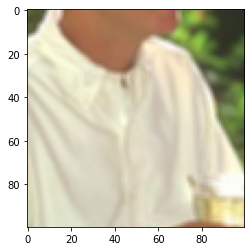

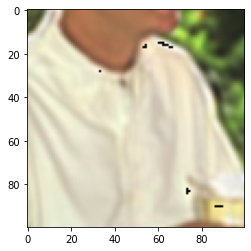

In [ ]:
####################### displaying zoomed in versions of the image to notice the difference

img_hsv[:,:,2] = out2
img_out = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
plt.imshow(img_out[100:200,100:200,:])
plt.show()

img_hsv[:,:,2] = out
img_out = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
plt.imshow(img_out[100:200,100:200,:])
plt.show()


## Applying RFR

In [ ]:
model = 'rfr'

0.06907577430272258
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320


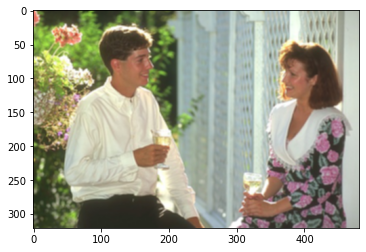

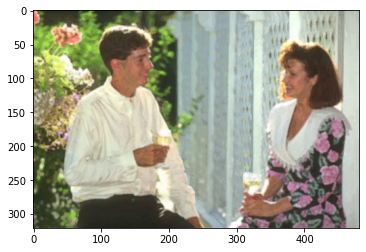

In [ ]:
 #################################### applying rfr model to the image (only on the v values)

if model == 'rfr':

  img_hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2HSV)                      ## convert bgr image to hsv
  img_v = img_hsv[:,:,2]                                                                ## extract intensity values

  # w_max = w_min_rfr_v                                                                            ## set optimum width for subpatches to generate centre pixel value
  w_max = 91

  out = np.zeros([img_v.shape[0],img_v.shape[1]])                                       ## initliase array to store output
  out2 = np.zeros([img_v.shape[0],img_v.shape[1]])                                      ## used to creat a copy of the original to compare with output

  img_padded = np.pad(img_v,((w_max//2,w_max//2),(w_max//2,w_max//2)),'mean')           ## add padding to the image (half the width of the subpatch on each side)
  # print(img_padded.shape)

  random_forest_regression_v(all_patches,all_centres,w_max,0.1)                  ## call the model to train it once (OPTIONAL)

  for row in range(img.shape[0]):                                                       ## traverse along rows
    if row%10==0:
      print(row)                                                                        ## to keep a track of image processed because it takes time
    for column in range(img.shape[1]):                                                  ## traverse laong columns (cells)
      X = img_padded[row:row+w_max,column:column+w_max].flatten().reshape(1,-1)             ## for each pixel, select a wxw width box of image
      X = sc_X_v.transform(X)                                                               ## scale it according to the standard scaler
      y_pred = regressor_rfr_v.predict(X)                                                   ## apply the regression model

      y_pred=y_pred.reshape(-1,1)
      # y_pred = sc_y_v.inverse_transform(y_pred)                                              ## transform the output back to its nromal value
      y_pred = y_pred.reshape(-1)*255
      # print(y_pred)

      out[row,column] = int(y_pred)%255                                                       ## intensity value shold be an integer between 0 and 255
      out2[row,column] = img_v[row,column]                                                     ## storing the image pixel value in out2

  img_hsv[:,:,2] = out2                                                                       
  img_out = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)                             ## convert back to bgr
  plt.imshow(img_out)                                                                             ## the original blurr image is displayed
  plt.show()

  img_hsv[:,:,2] = out
  img_out = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)                         ## convert back to bgr
  plt.imshow(img_out)                                                                          ## the transformed image is displayed
  plt.show()

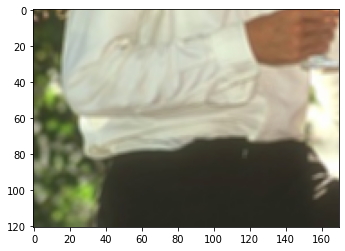

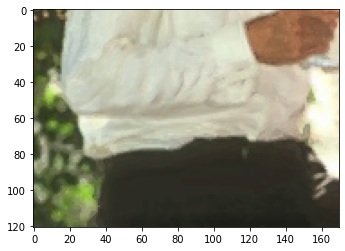

In [ ]:
####################### displaying zoomed in versions of the image to notice the difference



img_hsv[:,:,2] = out2
img_out = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
plt.imshow(img_out[200:400,30:200,:])
plt.show()

img_hsv[:,:,2] = out
img_out = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
plt.imshow(img_out[200:400,30:200,:])
plt.show()

We do see some deblurring effect in the RFR Regression model

Random forest regression was expected to work better than SVR Regression, and as we can see from the results, it indeed did

Random forest is a more complex model and hence brings out a better sharpenign effect than SVR regression model

In [ ]:
dump(sc_X_v, 'std_scaler.bin', compress=True)

['std_scaler.bin']

# Saving the models

In [ ]:
import torch

torch.save(random_forest_regression_v,'abc')

In [ ]:
joblib.dump(random_forest_regression_v, "my_random_forest.joblib")

['my_random_forest.joblib']

In [ ]:
with open('model_pkl', 'wb') as files:
    pickle.dump(random_forest_regression_v, files)

In [ ]:
dump(sc_X_v, 'std_scaler.bin', compress=True)

['std_scaler.bin']

In [ ]:
img_hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2HSV)                      ## convert bgr image to hsv
img_v = img_hsv[:,:,2]                                                                ## extract intensity values

# w_max = w_min_rfr_v                                                                            ## set optimum width for subpatches to generate centre pixel value
w_max = 91

out = np.zeros([img_v.shape[0],img_v.shape[1]])                                       ## initliase array to store output
out2 = np.zeros([img_v.shape[0],img_v.shape[1]])                                      ## used to creat a copy of the original to compare with output

img_padded = np.pad(img_v,((w_max//2,w_max//2),(w_max//2,w_max//2)),'mean')           ## add padding to the image (half the width of the subpatch on each side)
# print(img_padded.shape)

random_forest_regression_v(all_patches,all_centres,w_max,0.1)                  ## call the model to train it once (OPTIONAL)

for row in range(img.shape[0]):                                                       ## traverse along rows
  if row%10==0:
    print(row)                                                                        ## to keep a track of image processed because it takes time
  for column in range(img.shape[1]):                                                  ## traverse laong columns (cells)
    X = img_padded[row:row+w_max,column:column+w_max].flatten().reshape(1,-1)             ## for each pixel, select a wxw width box of image
    X = sc_X_v.transform(X)                                                               ## scale it according to the standard scaler
    y_pred = regressor_rfr_v.predict(X)                                                   ## apply the regression model

    y_pred=y_pred.reshape(-1,1)
    # y_pred = sc_y_v.inverse_transform(y_pred)                                              ## transform the output back to its nromal value
    y_pred = y_pred.reshape(-1)*255
    # print(y_pred)

    out[row,column] = int(y_pred)%255                                                       ## intensity value shold be an integer between 0 and 255
    out2[row,column] = img_v[row,column]                                                     ## storing the image pixel value in out2



0.07621762472618057
0
10
20
30
40
50


KeyboardInterrupt: ignored

In [ ]:
############################################ References
### https://colab.research.google.com/notebooks/gpu.ipynb 
### https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
### https://www.geeksforgeeks.org/opencv-python-program-to-blur-an-image/
### https://www.geeksforgeeks.org/how-to-generate-a-random-number-between-0-and-1-in-python/
### https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d
### https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
### https://www.geeksforgeeks.org/random-forest-regression-in-python/
### https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html